In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

- https://www.youtube.com/watch?v=ElmBrKyMXxs
- https://github.com/hans/ipython-notebooks/blob/master/tf/TF%20tutorial.ipynb
- https://github.com/ematvey/tensorflow-seq2seq-tutorials

In [2]:
from __future__ import division
import tensorflow as tf
from os import path
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from mylibs.tf_helper import getDefaultGPUconfig
from sklearn.metrics import r2_score
from mylibs.py_helper import factors
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from common import get_or_run_nn
from data_providers.price_history_dummy_seq2seq_data_provider \
    import PriceHistoryDummySeq2SeqDataProvider
from models.price_history_dummy_seq2seq import PriceHistoryDummySeq2Seq

/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
dtype = tf.float32
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = getDefaultGPUconfig()
%matplotlib inline

### Step 0 - hyperparams

vocab_size and max sequence length are the SAME thing

decoder RNN hidden units are usually same size as encoder RNN hidden units in translation but for our case it does not seem really to be a relationship there but we can experiment and find out later, not a priority thing right now

In [4]:
num_epochs = 10

num_features = 1
num_units = 400 #state size

input_len = 60
target_len = 30

batch_size = 47

#trunc_backprop_len = ??

### Step 1 - collect data (and/or generate them)

In [5]:
npz_path = '../price_history_03_dp_60to30_from_fixed_len.npz'

In [6]:
dp = PriceHistoryDummySeq2SeqDataProvider(npz_path=npz_path, batch_size=batch_size,
                                          )
dp.inputs.shape, dp.targets.shape

((11374, 60, 1), (11374, 30))

In [7]:
aa, bb, cc = dp.next()
aa.shape, bb.shape, cc.shape

((47, 60, 1), (47, 31), (47, 31, 1))

### Step 2 - Build model

In [10]:
model = PriceHistoryDummySeq2Seq(rng=random_state, dtype=dtype, config=config)

In [11]:
graph = model.getGraph(batch_size=batch_size,
                       num_units=num_units,
                       input_len=input_len,
                       target_len=target_len)

learning rate: 0.001000
60
Tensor("inputs/unstack:0", shape=(47, 1), dtype=float32)

Tensor("encoder_rnn_layer/rnn/basic_rnn_cell_59/Tanh:0", shape=(47, 400), dtype=float32)

31
Tensor("decoder_rnn_layer/unstack:0", shape=(47, 1), dtype=float32)

31
Tensor("decoder_rnn_layer/rnn/basic_rnn_cell/Tanh:0", shape=(47, 400), dtype=float32)

31
Tensor("readout_layer/add:0", shape=(47, 1), dtype=float32)

Tensor("predictions/Reshape:0", shape=(47, 31), dtype=float32)

Tensor("error/Select:0", shape=(47, 31), dtype=float32)

Tensor("error/Mean:0", shape=(), dtype=float32)



In [12]:
#show_graph(graph)

### Step 3 training the network

RECALL: baseline is around 4 for huber loss for current problem, anything above 4 should be considered as major errors

## Basic RNN cell without predictions - with EOS = 0

In [15]:
rnn_cell = PriceHistorySeq2Seq.RNN_CELLS.BASIC_RNN
num_epochs = 50
num_epochs, num_units, batch_size

(50, 400, 47)

In [16]:
def experiment():
    return model.run(
        npz_path=npz_path,
        epochs=num_epochs,
        batch_size=batch_size,
        num_units=num_units,
        input_len = input_len,
        target_len = target_len,
        rnn_cell=rnn_cell,
    )

In [17]:
dyn_stats = experiment()
#dyn_stats, preds_dict = get_or_run_nn(experiment, filename='003_rnn_slidewin_60to1')

epochs: 50
End Epoch 01 (15.165 secs): err(train) = 2.8966
End Epoch 02 (14.985 secs): err(train) = 1.9231
End Epoch 03 (14.970 secs): err(train) = 1.7198
End Epoch 04 (14.955 secs): err(train) = 1.5322
End Epoch 05 (14.959 secs): err(train) = 1.4043
End Epoch 06 (14.961 secs): err(train) = 1.3128
End Epoch 07 (14.979 secs): err(train) = 1.2558
End Epoch 08 (14.967 secs): err(train) = 1.1964
End Epoch 09 (14.961 secs): err(train) = 1.1444
End Epoch 10 (14.981 secs): err(train) = 1.0825
End Epoch 11 (14.969 secs): err(train) = 1.0598
End Epoch 12 (14.953 secs): err(train) = 1.0133
End Epoch 13 (14.955 secs): err(train) = 1.0060
End Epoch 14 (14.951 secs): err(train) = 1.0007
End Epoch 15 (14.948 secs): err(train) = 0.9708
End Epoch 16 (14.954 secs): err(train) = 0.9927
End Epoch 17 (14.954 secs): err(train) = 0.9698
End Epoch 18 (14.972 secs): err(train) = 1.3544
End Epoch 19 (14.963 secs): err(train) = 1.6110
End Epoch 20 (14.955 secs): err(train) = 1.3868
End Epoch 21 (14.962 secs): e

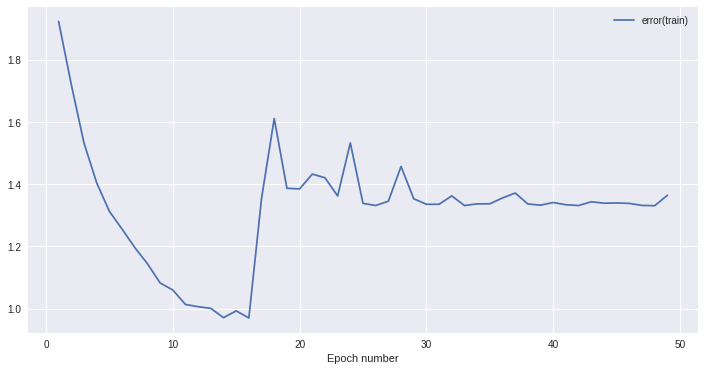

In [18]:
dyn_stats.plotStats()
plt.show()

#### Conclusion
//...

## Basic RNN cell - with EOS = 0

In [15]:
rnn_cell = PriceHistorySeq2Seq.RNN_CELLS.BASIC_RNN
num_epochs = 50
num_epochs, num_units, batch_size

(50, 400, 47)

In [21]:
def experiment():
    return model.run(
        npz_path=npz_path,
        epochs=num_epochs,
        batch_size=batch_size,
        num_units=num_units,
        input_len = input_len,
        target_len = target_len,
        rnn_cell=rnn_cell,
    )

In [22]:
dyn_stats, preds_dict = get_or_run_nn(experiment, filename='004_rnn_dummy_seq2seq_60to30')

epochs: 50
End Epoch 01 (15.138 secs): err(train) = 2.9598
End Epoch 02 (14.948 secs): err(train) = 1.9377
End Epoch 03 (14.948 secs): err(train) = 1.8119
End Epoch 04 (14.960 secs): err(train) = 1.6646
End Epoch 05 (14.975 secs): err(train) = 1.5313
End Epoch 06 (14.943 secs): err(train) = 1.3750
End Epoch 07 (14.948 secs): err(train) = 1.2382
End Epoch 08 (14.944 secs): err(train) = 1.1556
End Epoch 09 (14.946 secs): err(train) = 1.1133
End Epoch 10 (14.942 secs): err(train) = 1.0727
End Epoch 11 (14.947 secs): err(train) = 1.0242
End Epoch 12 (14.955 secs): err(train) = 1.0141
End Epoch 13 (14.968 secs): err(train) = 1.1222
End Epoch 14 (14.947 secs): err(train) = 1.9896
End Epoch 15 (14.937 secs): err(train) = 1.7050
End Epoch 16 (14.939 secs): err(train) = 1.5452
End Epoch 17 (14.937 secs): err(train) = 1.5140
End Epoch 18 (14.936 secs): err(train) = 1.3673
End Epoch 19 (14.936 secs): err(train) = 1.3600
End Epoch 20 (14.957 secs): err(train) = 1.3676
End Epoch 21 (14.950 secs): e

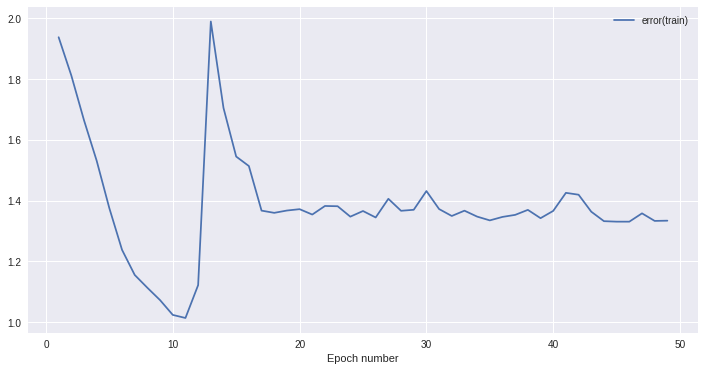

In [23]:
dyn_stats.plotStats()
plt.show()

In [24]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [25]:
ind = np.argmin(r2_scores)
ind

2685

In [26]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [27]:
r2_score(y_true=reals, y_pred=preds)

-7.8140015409473956e+29

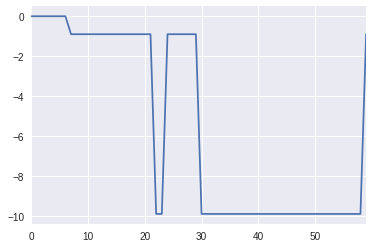

In [28]:
sns.tsplot(data=dp.inputs[ind].flatten())

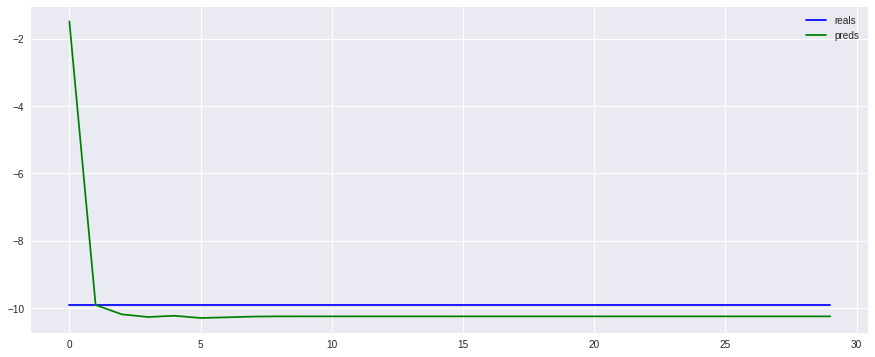

In [29]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [30]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 23.2 s, sys: 160 ms, total: 23.4 s
Wall time: 23.1 s


In [31]:
np.mean(dtw_scores)

14.421750079353133

In [32]:
coint(preds, reals)

(0.34817586687715174,
 0.99140382247108294,
 array([-4.31395736, -3.55493606, -3.19393252]))

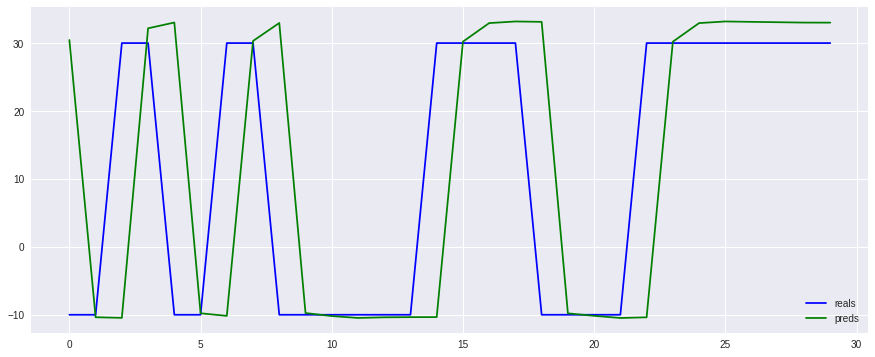

In [37]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

### Conclusion
They are obviously shifted...

## GRU cell - with EOS = 0

In [39]:
rnn_cell = PriceHistorySeq2Seq.RNN_CELLS.GRU
num_epochs = 20
num_epochs, num_units, batch_size

(20, 400, 47)

In [42]:
def experiment():
    return model.run(
        npz_path=npz_path,
        epochs=num_epochs,
        batch_size=batch_size,
        num_units=num_units,
        input_len = input_len,
        target_len = target_len,
        rnn_cell=rnn_cell,
    )

In [43]:
#dyn_stats = experiment()
dyn_stats, preds_dict = get_or_run_nn(experiment, filename='004_rnn_dummy_seq2seq_gru_60to30')

epochs: 20
End Epoch 01 (49.214 secs): err(train) = 2.1560
End Epoch 02 (48.331 secs): err(train) = 1.4913
End Epoch 03 (48.315 secs): err(train) = 1.4192
End Epoch 04 (48.335 secs): err(train) = 1.3746
End Epoch 05 (48.320 secs): err(train) = 1.3648
End Epoch 06 (48.329 secs): err(train) = 1.3307
End Epoch 07 (48.328 secs): err(train) = 1.3210
End Epoch 08 (48.310 secs): err(train) = 1.3307
End Epoch 09 (48.341 secs): err(train) = 1.3158
End Epoch 10 (48.320 secs): err(train) = 1.3033
End Epoch 11 (48.323 secs): err(train) = 1.3099
End Epoch 12 (48.336 secs): err(train) = 1.3099
End Epoch 13 (48.314 secs): err(train) = 1.2799
End Epoch 14 (48.349 secs): err(train) = 1.2736
End Epoch 15 (48.309 secs): err(train) = 1.2599
End Epoch 16 (48.339 secs): err(train) = 1.2294
End Epoch 17 (48.332 secs): err(train) = 1.1990
End Epoch 18 (48.313 secs): err(train) = 1.1806
End Epoch 19 (48.336 secs): err(train) = 1.1925
End Epoch 20 (48.317 secs): err(train) = 1.1593



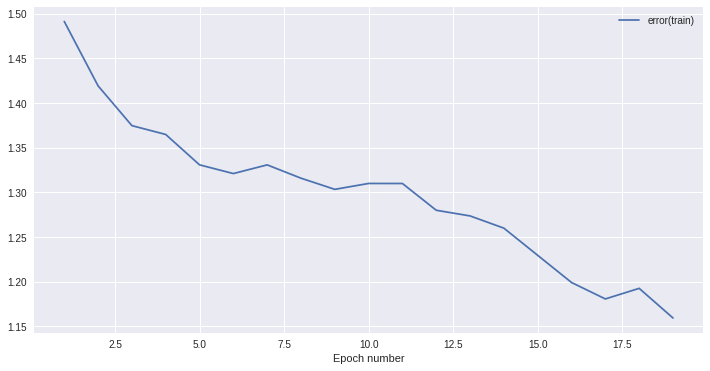

In [44]:
dyn_stats.plotStats()
plt.show()

In [45]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [46]:
ind = np.argmin(r2_scores)
ind

2685

In [47]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [48]:
r2_score(y_true=reals, y_pred=preds)

-7.7228746286792695e+29

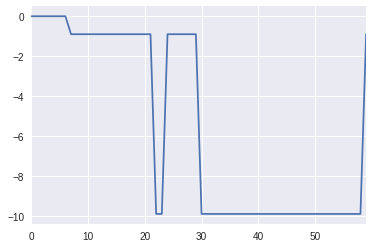

In [49]:
sns.tsplot(data=dp.inputs[ind].flatten())

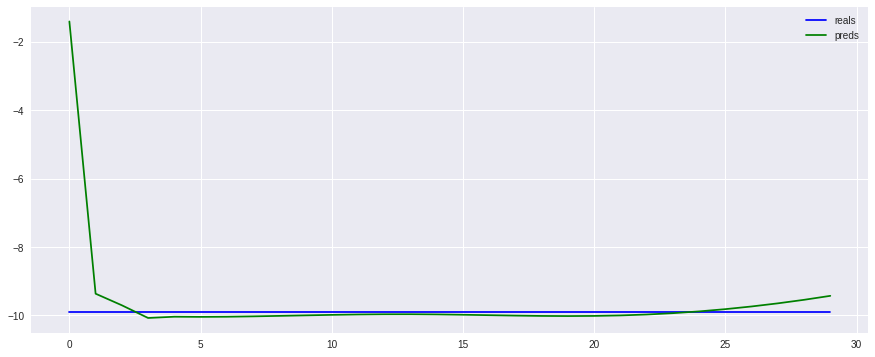

In [50]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [51]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 23.1 s, sys: 112 ms, total: 23.2 s
Wall time: 23.1 s


In [52]:
np.mean(dtw_scores)

11.581660654480876

In [53]:
coint(preds, reals)

(-3.6740349738820934,
 0.019781934439943423,
 array([-4.31395736, -3.55493606, -3.19393252]))

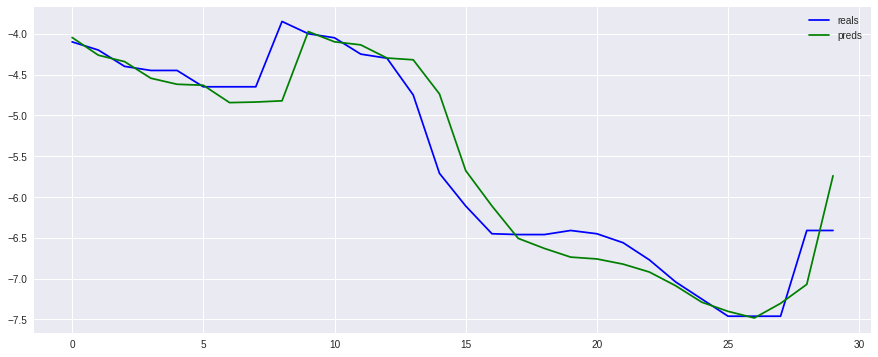

In [59]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()